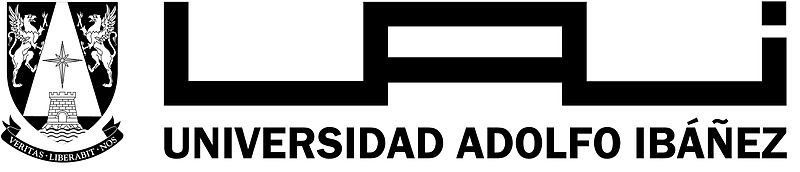

## Laboratorio S03 y S04: _Deep Learning_ - _Data augmentation_ , _transfer learning_ y Redes Convolucionales

#### Curso: Aprendizaje profundo
   
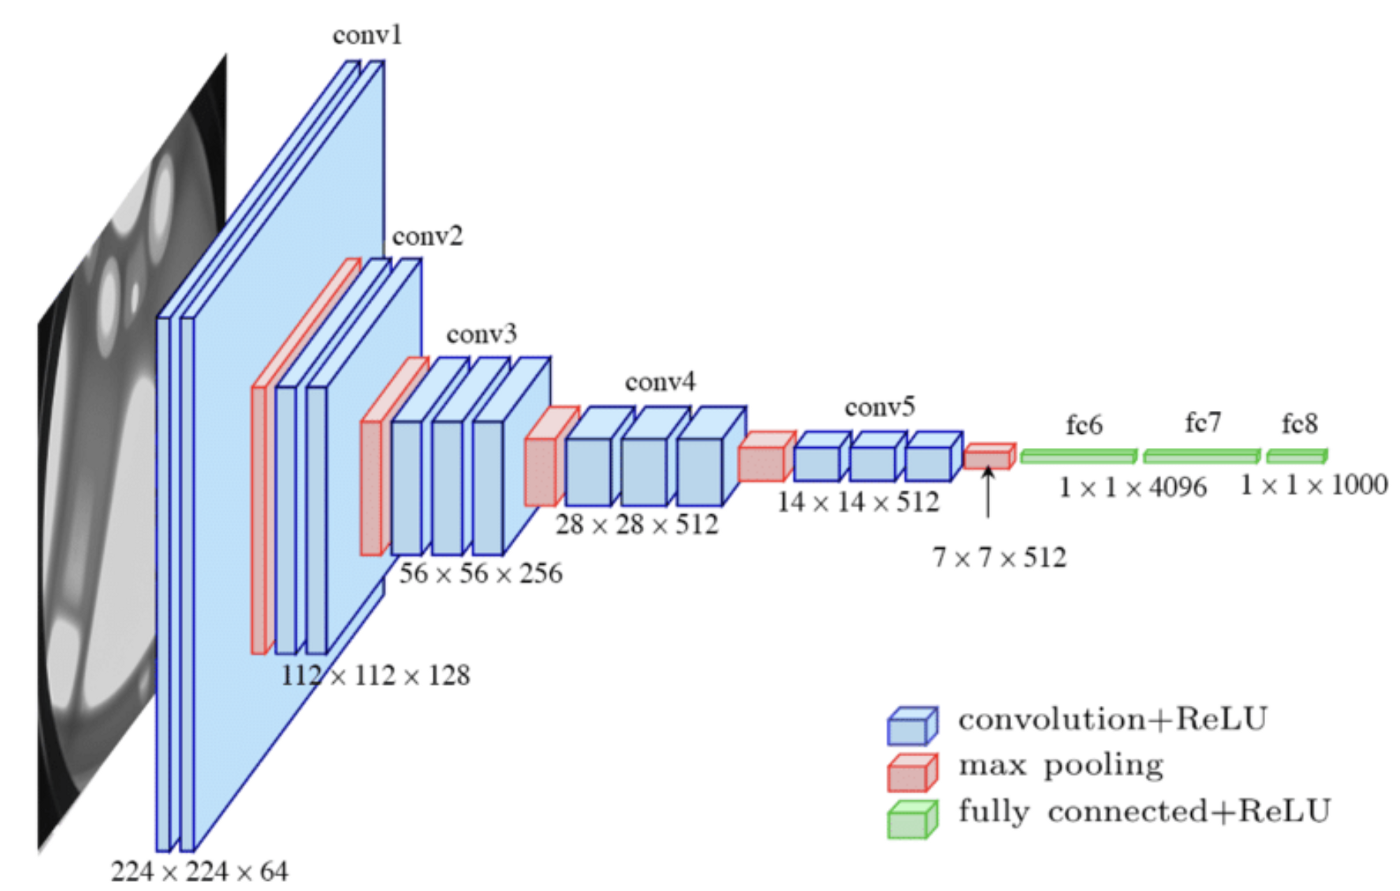

**Profesor**: Dr. Juan Bekios Calfa

**Grado**: MIA



#Objetivos

1. Entender el funcionamiento de una red convolucional, en especial, la arquitectura VGG-16.
2. Cargar los datos desde una base de datos Google Drive.
3. Crear un `Dataset` utilizando `ImageFolder`.
4. Entrenar las imágenes utilizando VGG16.
5. Aplicar los conceptos vistos en clases para entrenar una red ResNet.
6. Comparar los resultados obtenidos entre la red VGG y ResNet.
7. Proponer una red neuronal convolucional y comparar resultados.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/COQ-ESC-UCN/Classes/DeepLearning/UAI-1-2022/Lab/S4. Deep Learning II'

## 1. Cargar las librerías

In [ ]:
import torch # Cualquier librería pytorch
import torchvision # Cualquier librería pytorch
from torchvision import transforms, datasets  # Módulos para transformar imágenes a tensores y carga de dataset
import PIL # Librería para manipular imágenes en Python

## 2. Cargar imágenes

Se cargan las imágenes utilizando la clase **ImageFolder**. La clase ImageForder etiqueta automáticamente las imágenes dada una ruta donde se encuentran los datos. Por ejemplo, si tengo el directorio raíz dataset/training_set. Debo dejar mis imágenes de cada clase en una carpeta diferente. Si tengo imágenes de gatos debo dejarlos en dataset/training_set/cats, si tengo imágenes de perros las debo dejar en dataset/training_set/dogs, etc.

In [ ]:
data_transform = transforms.Compose([
        transforms.Resize((128,128)), # Escalar la imagen
        transforms.RandomHorizontalFlip(p=0.5), #
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1),
                                scale=None, shear=None,
                                resample=False, fillcolor=0),
        transforms.ColorJitter(brightness=(1, 1.5),
                               contrast=(0.3, 2),
                               saturation=(0.2, 2),
                               hue=(-0.3, 0.3)),
        transforms.RandomRotation((-5, 5), resample=PIL.Image.BILINEAR),
        transforms.ToTensor()
    ])

gatos_perros_dataset = datasets.ImageFolder(root='training_set',
                                           transform=data_transform)
print(gatos_perros_dataset)
dataset_loader = torch.utils.data.DataLoader(gatos_perros_dataset,
                                             batch_size=32, shuffle=False,
                                             num_workers=0)
print(dataset_loader)

## 3. Visualizo las imágenes cargadas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

def imshow(img):
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))

# Obtener imagenes
data_iter = iter(dataset_loader)
images, labels = data_iter.next()

# Mostrar imagenes
imshow(torchvision.utils.make_grid(images))

## 4. Separando la base de datos

Para realizar el entrenamiento y pruebas se recomienda separar los datos en tres conjuntos:

* **Conjunto de entrenamiento:** El modelo aprende de los ejemplos de este conjunto de datos. Se ajusta un parámetro a un clasificador.
* **Conjunto de validación:** Los ejemplos en el conjunto de datos de validación se utilizan para ajustar los hiperparámetros, como la tasa de aprendizaje y las épocas. El objetivo de crear un conjunto de validación es evitar un sobreajuste grande del modelo. Es un punto de control para saber si el modelo se ajusta bien con el conjunto de datos de entrenamiento.
* **Conjunto de pruebas:** Este conjunto de datos prueba la evolución final del modelo, midiendo qué tan bien aprendió y predijo el resultado deseado. Contiene datos invisibles de la vida real. Es un conjunto diferente al de entrenamiento y validación.

Imagen: [https://i.imgur.com/DV80uhS.png](https://i.imgur.com/DV80uhS.png)

In [ ]:
# Transformaciones sobre las imágenes
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# Carga de las imágenes
gatos_perros_train = datasets.ImageFolder(root='training_set',
                                           transform=data_transform)
gatos_perros_valid = datasets.ImageFolder(root='valid_set',
                                           transform=data_transform)
gatos_perros_test = datasets.ImageFolder(root='test_set',
                                           transform=data_transform)

# Conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(gatos_perros_train,
                                             batch_size=32, shuffle=True,
                                             num_workers=2)

# Conjunto de validación
valid_loader = torch.utils.data.DataLoader(gatos_perros_valid,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

# Conjunto de pruebas
test_loader = torch.utils.data.DataLoader(gatos_perros_test,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

In [ ]:
print(list(train_loader.sampler))

### Revisamos las imagenes de las nuevas cargas



In [ ]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

# Obtener imagenes
data_iter = iter(test_loader)
images, labels = data_iter.next()

# Mostrar imagenes
imshow(torchvision.utils.make_grid(images))

## 5. El modelo

Construimos un modelo con dos capas convolucionales, un dropout y dos capas completamente conectadas para la clasificación.

* Imagen red: [https://i.imgur.com/wiP9IwZ.png](https://i.imgur.com/wiP9IwZ.png)
* Imagen Conv: https://i.imgur.com/E9GGJMJ.gif
* Imagen Pool: https://i.imgur.com/kSwID7J.png

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x): # Calcular la predicción
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

### Creamos el modelo

In [ ]:
model = CNN()
print(model)

In [ ]:
import torchvision.models as models 
from torchsummary import summary 

summary(model.to(device), (3, 32, 32))

## 6. Optimización

Seleccionamos cualquier algoritmo optimizador disponible en el paquete `torch.optim`. En general, los optimizadores son moficaciones del descenso del gradiente. Cambiando los parámetros del modelo, como los pesos, y añadiendo sesgo, el modelo puede ser optimizado. La **tasa de aprendizaje** decidirá cuán grandes deben ser los pasos para cambiar los parámetros.

* Calcular lo que un pequeño cambio en cada peso haría a la función de pérdida (seleccionando la dirección para alcanzar los mínimos).
* Ajustar cada peso en función de su gradiente (es decir, dar un pequeño paso en la dirección determinada).
* Continúe haciendo los pasos 1 y 2 hasta que la función de pérdida sea lo más baja posible.

Aquí, la estimación del momento adaptativo (*adaptive moment estimation* - Adam) se utiliza como un optimizador. Es una mezcla de **RMSprop** y **descenso de gradiente estocástico**.

### Configuración de Hyperparámetros

In [ ]:
# Hyper parameters
num_epochs = 35
num_classes = 2
batch_size = 25
learning_rate = 0.01

### Configuración del dispositivo

In [ ]:
# CPU or GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

### Optimizador

In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

## 7. Entrenamiento

In [ ]:
#%%timeit

# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

### 7.1 Graficamos los resultados

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Pérdida entrenamiento y validación')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

## 8. Pruebas


In [ ]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
#torch.save(model.state_dict(), 'model.ckpt')

## 10. Modelos pre-entrenados

Hasta el momento hemos aprendido a configurar nuestra propia red neuronal artificial. ¿Pero estoy seguro de que la red neuronal artificial propuestas es la mejor?

Otra forma de crear modelos es utilizar modelos neuronales probados y entrenados.

En Python existen muchos modelos implementados:

* VGG16 (Y sus variaciones)
* Resnet18
* Alexnet
* Squeezenet 
* Densenet 
* Inception 
* GoogLeNet 
* Shufflenet
* Mobilenet 

### 10.1 Arquitectura VGG16

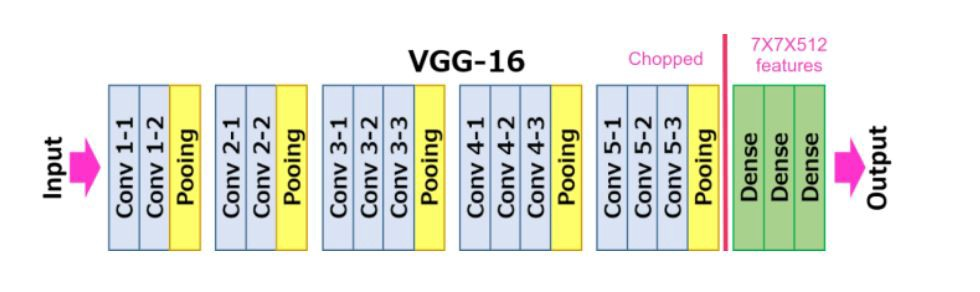

Para los experimentos de este laboratorio utilizaremos la arquitectura de red neuronal profunda VGG16. La cual es está compuesta por 5 grupos de capas para la extracción de características. Cada grupo de capas  está compuesta de capas convolucionales y una de pooling para reducción de dimensiones.

Para cargar la red desde Pytorch se deben ejecutar los siguientes pasos:

In [ ]:
import torch
import torchvision.models as models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_vgg16 = models.vgg16(pretrained=True)

In [ ]:
# Mostramos el modelo cargado
print(model_vgg16)

### 10.2 Seleccionando la parte del modelo a utilizar

Para utilizar el modelo pre-cargado, solo utilizamos la parte entrenada donde fueron se filtran las características. La red completamentamente conectada (fully-conected) es reemplazada para nuestro problema.

In [ ]:
for parma in model_vgg16.parameters():
    parma.requires_grad = False

model_vgg16.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 2))

print(model_vgg16)

### 10.3 Optimización

Dejamos libre todos los pesos para que sean entrenados en la red de clasificación.

In [ ]:
for index, parma in enumerate(model_vgg16.classifier.parameters()):
#   if index == 6:
#       
  parma.requires_grad = True
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg16.classifier.parameters())

print(model_vgg16)
model_vgg16 = model_vgg16.to(device)

### 10.4 Revisar los parámetros correctos

In [ ]:
import torchvision.models as models 
from torchsummary import summary 

summary(model_vgg16, (3, 300, 300))

### 10.5 Entrenamiento

#### 10.5.1 Cargar los datos 

In [ ]:
from torchvision import transforms, datasets  # Módulos para transformar imágenes a tensores y carga de dataset
import PIL # Librería para manipular imágenes en Python

# Transformaciones sobre las imágenes
data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# Carga de las imágenes
gatos_perros_train = datasets.ImageFolder(root='training_set',
                                           transform=data_transform)
gatos_perros_valid = datasets.ImageFolder(root='valid_set',
                                           transform=data_transform)
gatos_perros_test = datasets.ImageFolder(root='test_set',
                                           transform=data_transform)

# Conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(gatos_perros_train,
                                             batch_size=32, shuffle=True,
                                             num_workers=2)

# Conjunto de validación
valid_loader = torch.utils.data.DataLoader(gatos_perros_valid,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

# Conjunto de pruebas
test_loader = torch.utils.data.DataLoader(gatos_perros_test,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

#### 10.5.2 Entrenamiento de los datos

In [ ]:
#%%timeit

num_epochs = 2


# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model_vgg16.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model_vgg16(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model_vgg16.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model_vgg16(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

## 10.6 Graficamos los resultados

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Pérdida entrenamiento y validación')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

# Tasa de acierto conjunto de pruebas

In [ ]:
# test-the-model
model_vgg16.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
#torch.save(model.state_dict(), 'model.ckpt')

# TAREA:

Implementar y resolver los objetivos 5, 6 y 7.

**Fecha de entrega:** 11 de abril del 2022.

## Objetivo 5: Aplicar los conceptos vistos en clases para entrenar una red ResNet.


## Objetivo 6: Comparar los resultados obtenidos entre la red VGG y ResNet.


## Objetivo 7: Proponer una red neuronal convolucional y comparar resultados.

## Resultados generales

Comparar los resultados del objetivo 5, 6 y 7.

## Conclusiones